# Assignment 2

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

### Titanic Dataset

In [2]:
class TitanicDataset(Dataset):
    """Titanic dataset."""

    def __init__(self, csv_file, train=True, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            train (callable, optional): Optional to receive training (train=true) or test data.
        """

        self.transform = transform
        self.titanic_table = pd.read_csv(csv_file)
        self.train = train

        self.titanic_table = self.titanic_table[["Age", "Pclass", "SibSp", "Parch", "Fare", "Sex", "Embarked", "Survived"]]
        self.titanic_table = self.titanic_table.dropna()
        self.titanic_table = pd.get_dummies(self.titanic_table)

        self.titanic_y = self.titanic_table.pop("Survived")

        self.titanic_train, self.titanic_test, self.y_train, self.y_test = train_test_split(self.titanic_table, self.titanic_y, test_size=0.2, random_state=42)

        self.scaler = MinMaxScaler()
        self.titanic_train = self.scaler.fit_transform(self.titanic_train)
        self.titanic_test = self.scaler.transform(self.titanic_test)
    
    def __len__(self):
        if self.train:
            return len(self.titanic_train)
        return len(self.titanic_test)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if not self.train:
            self.titanic_train = self.titanic_test
            self.y_train = self.y_test

        data = np.float32(self.titanic_train[idx,:])
        ys = np.array([self.y_train.iloc[idx]], dtype="float32").reshape(-1)

        sample = {'row': data, 'label': ys}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        row, ys = sample['row'], sample['label']

        return {'row': torch.from_numpy(row),
                'label': torch.from_numpy(ys)}

### Netz trainieren

In [4]:
num_epochs = 30
batch_size_training = 5
batch_size_validating = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(TitanicDataset('./data/titanic.csv', train=True, transform=ToTensor()), batch_size=batch_size_training, shuffle=True)

test_loader = torch.utils.data.DataLoader(TitanicDataset('./data/titanic.csv', train=False, transform=ToTensor()), batch_size=batch_size_validating, shuffle=True)

In [6]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    self.sig = torch.nn.Sigmoid()

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return self.sig(y_pred)

In [7]:
# Construct model with 10 collumn input, 3 neuron hidden layer, and 1 neuron output layer
network = TwoLayerNet(10, 3, 1)

# Init optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
# lists holding training data
train_losses = []
train_counter = []
test_losses = []
# number for each training pass
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

In [9]:
def train(epoch):
  network.train()

  loss_fn = torch.nn.BCELoss()
  for batch_idx, sample_batched in enumerate(train_loader):

    #print(sample_batched['row'].dtype, sample_batched['label'])
    #print(batch_idx)
    # Set gradient to zero
    optimizer.zero_grad()
      
    # Forward pass
    output = network(sample_batched['row'])

    # Compute loss
    #print(output, sample_batched['label'])
    #loss = loss_fn(output, sample_batched['label'])
    loss = torch.nn.functional.binary_cross_entropy(output, sample_batched['label'])

    # Zero gradients, perform a backward pass, and update the weights.
    #optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(sample_batched['row']), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_training) + ((epoch-1)*len(train_loader.dataset)))

In [10]:
def test(loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(loader):
          output = network(sample_batched['row'])
          test_loss += torch.nn.functional.binary_cross_entropy(output, sample_batched['label'], size_average=False).item()
          #pred = output.data.max(1, keepdim=True)[1]
          #print(sample_batched['label'])
          #print(output.data > 0.5)
          pred = output.data > 0.5
          #print(pred.eq(sample_batched['label'].data.view_as(pred)))
          #print(pred.eq(sample_batched['label'].data.view_as(pred)).sum())
          #print(output.data.max(1, keepdim=True))
          correct += pred.eq(sample_batched['label'].data.view_as(pred)).sum()
          #print(pred.eq(sample_batched['label'].data.view_as(pred)))
    accuracy = 100. * correct / len(loader.dataset)
    test_loss /= len(loader.dataset)
    test_losses.append(test_loss)
    print('\nSet: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))
    return accuracy

In [11]:
training_accuracy = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train(epoch)
    training_accuracy.append(test(train_loader))
    test_accuracy.append(test(test_loader))

Train Epoch: 1 [0/569 (0%)]	Loss: 0.696307
Train Epoch: 1 [50/569 (9%)]	Loss: 0.683404
Train Epoch: 1 [100/569 (18%)]	Loss: 0.697161
Train Epoch: 1 [150/569 (26%)]	Loss: 0.686904
Train Epoch: 1 [200/569 (35%)]	Loss: 0.648653
Train Epoch: 1 [250/569 (44%)]	Loss: 0.701439
Train Epoch: 1 [300/569 (53%)]	Loss: 0.689476
Train Epoch: 1 [350/569 (61%)]	Loss: 0.690316
Train Epoch: 1 [400/569 (70%)]	Loss: 0.639554
Train Epoch: 1 [450/569 (79%)]	Loss: 0.562095
Train Epoch: 1 [500/569 (88%)]	Loss: 0.786851
Train Epoch: 1 [550/569 (96%)]	Loss: 0.524999

Set: Avg. loss: 0.6093, Accuracy: 351/569 (62%)


Set: Avg. loss: 0.6326, Accuracy: 82/143 (57%)

Train Epoch: 2 [0/569 (0%)]	Loss: 0.690869
Train Epoch: 2 [50/569 (9%)]	Loss: 0.806888
Train Epoch: 2 [100/569 (18%)]	Loss: 0.531998
Train Epoch: 2 [150/569 (26%)]	Loss: 0.588175
Train Epoch: 2 [200/569 (35%)]	Loss: 0.736528
Train Epoch: 2 [250/569 (44%)]	Loss: 0.358589
Train Epoch: 2 [300/569 (53%)]	Loss: 0.455690
Train Epoch: 2 [350/569 (61%)]	Loss: 

/home/ruwen/miniconda3/envs/kilab/lib/python3.12/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [550/569 (96%)]	Loss: 0.699701

Set: Avg. loss: 0.5619, Accuracy: 430/569 (76%)


Set: Avg. loss: 0.5947, Accuracy: 103/143 (72%)

Train Epoch: 3 [0/569 (0%)]	Loss: 0.446153
Train Epoch: 3 [50/569 (9%)]	Loss: 0.320985
Train Epoch: 3 [100/569 (18%)]	Loss: 0.717056
Train Epoch: 3 [150/569 (26%)]	Loss: 0.458337
Train Epoch: 3 [200/569 (35%)]	Loss: 0.588790
Train Epoch: 3 [250/569 (44%)]	Loss: 0.475496
Train Epoch: 3 [300/569 (53%)]	Loss: 0.596836
Train Epoch: 3 [350/569 (61%)]	Loss: 0.393793
Train Epoch: 3 [400/569 (70%)]	Loss: 0.376711
Train Epoch: 3 [450/569 (79%)]	Loss: 0.356981
Train Epoch: 3 [500/569 (88%)]	Loss: 0.521781
Train Epoch: 3 [550/569 (96%)]	Loss: 0.630614

Set: Avg. loss: 0.5302, Accuracy: 453/569 (80%)


Set: Avg. loss: 0.5748, Accuracy: 108/143 (76%)

Train Epoch: 4 [0/569 (0%)]	Loss: 0.529795
Train Epoch: 4 [50/569 (9%)]	Loss: 0.309653
Train Epoch: 4 [100/569 (18%)]	Loss: 0.458294
Train Epoch: 4 [150/569 (26%)]	Loss: 0.489407
Train Epoch: 4 [200/569 (35%

### Diagramm für unmodifiziertes Netz

Text(0, 0.5, 'accuracy')

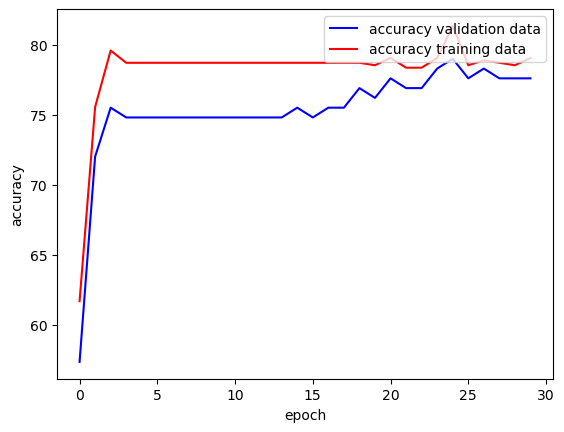

In [12]:
fig = plt.figure()
plt.plot(test_accuracy, color='blue')
plt.plot(training_accuracy, color='red')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['accuracy validation data', 'accuracy training data'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

### Modifiziertes Netz trainieren

In [13]:
class TwoLayerNetOverfit(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNetOverfit, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, H)
    self.linear3 = torch.nn.Linear(H, H)
    self.linear4 = torch.nn.Linear(H, H)
    self.linear5 = torch.nn.Linear(H, H)
    self.linear6 = torch.nn.Linear(H, H)
    self.linear7 = torch.nn.Linear(H, D_out)
    self.sig = torch.nn.Sigmoid()

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu_one = self.linear1(x).clamp(min=0)
    h_relu_two = self.linear2(h_relu_one).clamp(min=0)
    h_relu_three = self.linear3(h_relu_two).clamp(min=0)
    h_relu_four = self.linear4(h_relu_three).clamp(min=0)
    h_relu_five = self.linear5(h_relu_four).clamp(min=0)
    h_relu_six = self.linear6(h_relu_five).clamp(min=0)
    y_pred = self.linear7(h_relu_six)
    return self.sig(y_pred)

In [14]:
num_epochs = 50
batch_size_training = 5
batch_size_validating = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 10


# Construct model with 10 collumn input, two 1000 neuron hidden layer, and 1 neuron output layer
network = TwoLayerNetOverfit(10, 1000, 1)

# Init optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# lists holding training data
train_losses = []
train_counter = []
test_losses = []
# number for each training pass
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]


In [15]:
training_accuracy = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train(epoch)
    training_accuracy.append(test(train_loader))
    test_accuracy.append(test(test_loader))

Train Epoch: 1 [0/569 (0%)]	Loss: 0.695507
Train Epoch: 1 [50/569 (9%)]	Loss: 0.694718
Train Epoch: 1 [100/569 (18%)]	Loss: 0.686742
Train Epoch: 1 [150/569 (26%)]	Loss: 0.684344
Train Epoch: 1 [200/569 (35%)]	Loss: 0.683436
Train Epoch: 1 [250/569 (44%)]	Loss: 0.683450
Train Epoch: 1 [300/569 (53%)]	Loss: 0.651572
Train Epoch: 1 [350/569 (61%)]	Loss: 0.679099
Train Epoch: 1 [400/569 (70%)]	Loss: 0.642077
Train Epoch: 1 [450/569 (79%)]	Loss: 0.718633
Train Epoch: 1 [500/569 (88%)]	Loss: 0.760648
Train Epoch: 1 [550/569 (96%)]	Loss: 0.721377

Set: Avg. loss: 0.6745, Accuracy: 344/569 (60%)


Set: Avg. loss: 0.6851, Accuracy: 80/143 (56%)

Train Epoch: 2 [0/569 (0%)]	Loss: 0.814009
Train Epoch: 2 [50/569 (9%)]	Loss: 0.640042
Train Epoch: 2 [100/569 (18%)]	Loss: 0.640161
Train Epoch: 2 [150/569 (26%)]	Loss: 0.676585
Train Epoch: 2 [200/569 (35%)]	Loss: 0.677279
Train Epoch: 2 [250/569 (44%)]	Loss: 0.579498
Train Epoch: 2 [300/569 (53%)]	Loss: 0.790637
Train Epoch: 2 [350/569 (61%)]	Loss: 

### Diagramm für modifiziertes Netz

Text(0, 0.5, 'accuracy')

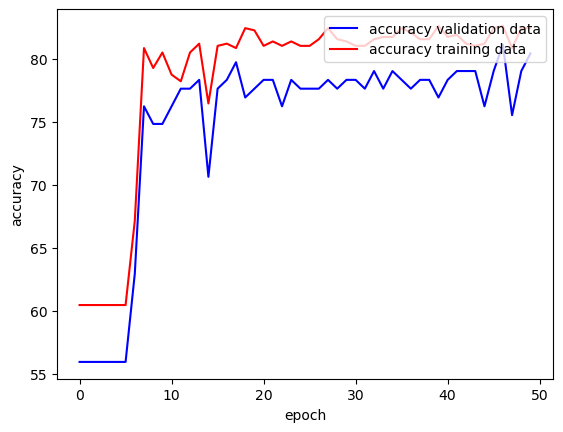

In [16]:
fig = plt.figure()
plt.plot(test_accuracy, color='blue')
plt.plot(training_accuracy, color='red')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['accuracy validation data', 'accuracy training data'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

### Modifiziertes Netz mit Dropout Layer

In [17]:
class TwoLayerNetDropout(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNetDropout, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, H)
    self.dropout1 = torch.nn.Dropout(0.2)
    self.linear3 = torch.nn.Linear(H, H)
    self.dropout2 = torch.nn.Dropout(0.2)
    self.linear4 = torch.nn.Linear(H, H)
    self.dropout3 = torch.nn.Dropout(0.2)
    self.linear5 = torch.nn.Linear(H, H)
    self.dropout4 = torch.nn.Dropout(0.2)
    self.linear6 = torch.nn.Linear(H, H)
    self.linear7 = torch.nn.Linear(H, D_out)
    self.sig = torch.nn.Sigmoid()

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu_one = self.linear1(x).clamp(min=0)
    h_relu_two = self.linear2(h_relu_one).clamp(min=0)
    h_relu_tow = self.dropout1(h_relu_two)
    h_relu_three = self.linear3(h_relu_two).clamp(min=0)
    h_relu_three = self.dropout2(h_relu_three)
    h_relu_four = self.linear4(h_relu_three).clamp(min=0)
    h_relu_four = self.dropout3(h_relu_four)
    h_relu_five = self.linear5(h_relu_four).clamp(min=0)
    h_relu_five = self.dropout4(h_relu_five)
    h_relu_six = self.linear6(h_relu_five).clamp(min=0)
    y_pred = self.linear7(h_relu_six)
    return self.sig(y_pred)

In [18]:
num_epochs = 50
batch_size_training = 5
batch_size_validating = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 10


# Construct model with 10 collumn input, two 1000 neuron hidden layer, and 1 neuron output layer
network = TwoLayerNetDropout(10, 1000, 1)

# Init optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# lists holding training data
train_losses = []
train_counter = []
test_losses = []
# number for each training pass
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

In [19]:
training_accuracy = []
test_accuracy = []

for epoch in range(1, num_epochs + 1):
    train(epoch)
    training_accuracy.append(test(train_loader))
    test_accuracy.append(test(test_loader))

Train Epoch: 1 [0/569 (0%)]	Loss: 0.691013
Train Epoch: 1 [50/569 (9%)]	Loss: 0.688484
Train Epoch: 1 [100/569 (18%)]	Loss: 0.703846
Train Epoch: 1 [150/569 (26%)]	Loss: 0.682630
Train Epoch: 1 [200/569 (35%)]	Loss: 0.680194
Train Epoch: 1 [250/569 (44%)]	Loss: 0.679246
Train Epoch: 1 [300/569 (53%)]	Loss: 0.643924
Train Epoch: 1 [350/569 (61%)]	Loss: 0.709908
Train Epoch: 1 [400/569 (70%)]	Loss: 0.609249
Train Epoch: 1 [450/569 (79%)]	Loss: 0.764129
Train Epoch: 1 [500/569 (88%)]	Loss: 0.627887
Train Epoch: 1 [550/569 (96%)]	Loss: 0.722243

Set: Avg. loss: 0.6746, Accuracy: 344/569 (60%)


Set: Avg. loss: 0.6854, Accuracy: 80/143 (56%)

Train Epoch: 2 [0/569 (0%)]	Loss: 0.770694
Train Epoch: 2 [50/569 (9%)]	Loss: 0.629932
Train Epoch: 2 [100/569 (18%)]	Loss: 0.675298
Train Epoch: 2 [150/569 (26%)]	Loss: 0.674388
Train Epoch: 2 [200/569 (35%)]	Loss: 0.728526
Train Epoch: 2 [250/569 (44%)]	Loss: 0.673655
Train Epoch: 2 [300/569 (53%)]	Loss: 0.673017
Train Epoch: 2 [350/569 (61%)]	Loss: 

### Diagramm für Netz mit Dropout

Text(0, 0.5, 'accuracy')

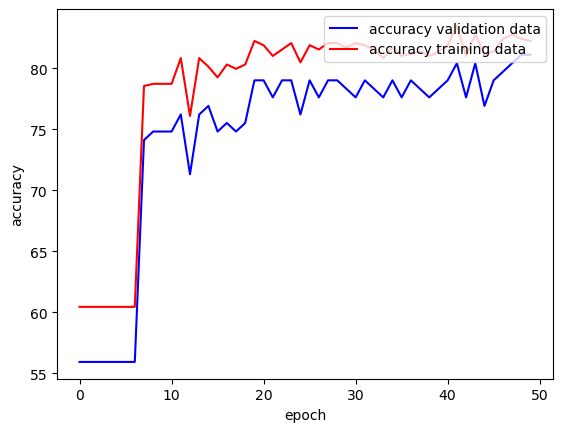

In [20]:
fig = plt.figure()
plt.plot(test_accuracy, color='blue')
plt.plot(training_accuracy, color='red')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['accuracy validation data', 'accuracy training data'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('accuracy')